In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [2]:
deeplabv3plus_srcdir="./src"
sys.path.append(deeplabv3plus_srcdir)

In [3]:
gpu_options = tf.compat.v1.GPUOptions(visible_device_list="0", allow_growth=True)
config = tf.compat.v1.ConfigProto(gpu_options = gpu_options)
tf.compat.v1.enable_eager_execution(config=config)

In [4]:
from model import deeplab_v3plus_transfer_os16
#from image_utils import make_x_from_image_paths,make_y_from_image_paths,convert_y_to_image_array
from data_gen import DataGenerator
from metrics import IoU
from label import Label

In [5]:
out_dir = "polygon_test"
os.makedirs(out_dir, exist_ok=True)

In [6]:
traindata_dir = '../kaigan_block/dataset/poly/train'
testdata_dir = '../kaigan_block/dataset/x_test2'

train_x_paths = glob.glob(os.path.join(traindata_dir,'*.jpg'))
train_x_paths.sort()
image_names = [os.path.basename(train_x_paths[i]).split('.')[0] for i in range(len(train_x_paths))]
train_y_paths=[]
for i, image_name in enumerate(image_names):
    p = os.path.join(traindata_dir, image_name+'.json')
    if os.path.exists(p):
        train_y_paths.append(p)
    else:
        train_y_paths.append(None)

In [7]:
label_file_path = os.path.join(traindata_dir, 'label_list.csv')
label = Label(label_file_path)
image_size = (512,512)

In [8]:
batch_size=3
n_epochs=300

In [9]:
encoder = keras.applications.Xception(input_shape=(512,512,3), weights="imagenet", include_top=False)
preprocess = keras.applications.xception.preprocess_input
layer_name_to_decoder = "block3_sepconv2_bn"
encoder_end_layer_name = "block13_sepconv2_bn"
model = deeplab_v3plus_transfer_os16(label.n_labels, encoder, layer_name_to_decoder, encoder_end_layer_name)

W1205 15:39:38.950723 140735419010256 module_wrapper.py:139] From ./src/model.py:222: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



in decoder, layer from encoder is resized from (?, 127, 127, 256) to (?, 128, 128, 256)


In [10]:
train_data_gen = DataGenerator(train_x_paths, train_y_paths, image_size, label, batch_size, preprocess, augmentation=True, shuffle=True, data_type="polygon")

In [11]:
loss_function = tf.keras.losses.categorical_crossentropy
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss=loss_function, metrics=[IoU])

In [12]:
filepath = os.path.join(out_dir,'{epoch:06d}.h5')
cp_cb = keras.callbacks.ModelCheckpoint(filepath, 
                                        #monitor='val_IoU', 
                                        monitor='IoU', 
                                        verbose=1, 
                                        save_best_only=True, 
                                        save_weights_only=False, 
                                        mode='max')

In [13]:
len(train_data_gen)

2

In [14]:
hist = model.fit_generator(train_data_gen,
                           epochs=n_epochs,
                           steps_per_epoch=len(train_data_gen),
                           #validation_data=valid_data_gen,
                           #validation_steps=len(valid_data_gen),
                           #shuffle = False,
                           workers=8,
                           use_multiprocessing=True,
                           callbacks=[cp_cb])

Epoch 1/300


W1205 15:39:43.675503 140735419010256 deprecation.py:323] From /home/taniguchi-j/anaconda3/envs/ppc/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1394: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1/2 [==============>...............] - ETA: 4s - loss: 1.4041 - IoU: 0.1454
Epoch 00001: IoU improved from -inf to 0.18661, saving model to polygon_test/000001.h5
2/2 [==============================] - 6s 3s/step - loss: 1.2737 - IoU: 0.1866
Epoch 2/300
1/2 [==============>...............] - ETA: 0s - loss: 0.7689 - IoU: 0.4668
Epoch 00002: IoU improved from 0.18661 to 0.41377, saving model to polygon_test/000002.h5
2/2 [==============================] - 1s 730ms/step - loss: 0.8667 - IoU: 0.4138
Epoch 3/300
1/2 [==============>...............] - ETA: 0s - loss: 0.6529 - IoU: 0.5813
Epoch 00003: IoU improved from 0.41377 to 0.57257, saving model to polygon_test/000003.h5
2/2 [==============================] - 2s 760ms/step - loss: 0.6611 - IoU: 0.5726
Epoch 4/300
1/2 [==============>...............] - ETA: 0s - loss: 0.6375 - IoU: 0.6002
Epoch 00004: IoU improved from 0.57257 to 0.60452, saving model to polygon_test/000004.h5
2/2 [==============================] - 1s 728ms/step - loss:

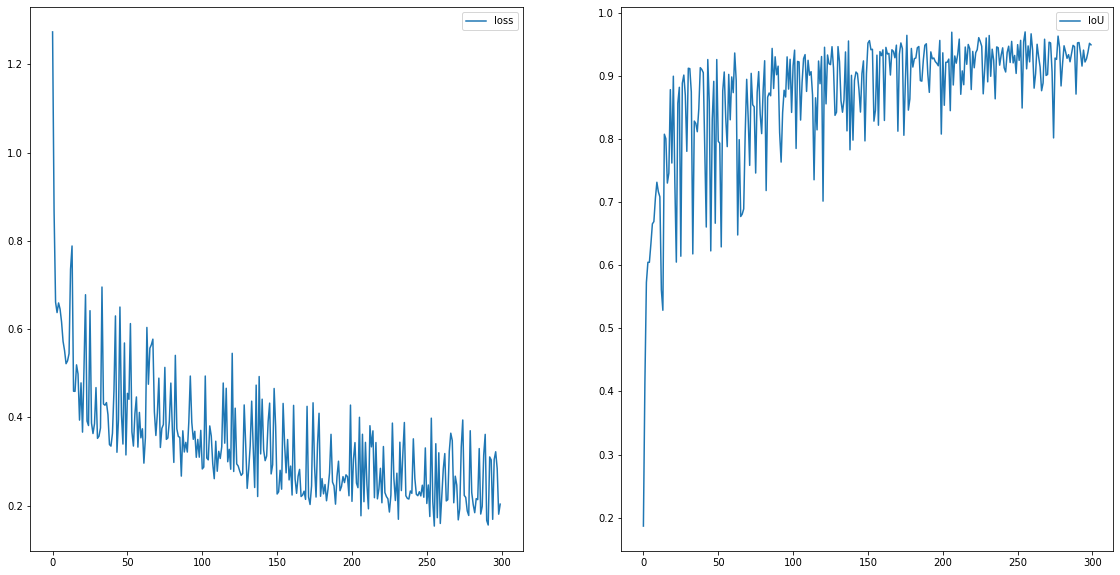

In [15]:
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.plot(hist.history["loss"], label="loss")
#plt.plot(hist.history["val_loss"], label="val_loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(hist.history["IoU"], label="IoU")
#plt.plot(hist.history["val_IoU"], label="val_IoU")
plt.legend()
plt.savefig(os.path.join(out_dir,'losscurve.png'))

In [16]:
model.save(os.path.join(out_dir,'final_epoch.h5'))
for key in sorted(hist.history.keys()):
    np.savetxt(os.path.join(out_dir,key+'.txt'),np.array(hist.history[key]))
